In [ ]:
rm -rf *tinydb jobs/*

In [1]:
import sys
import qgrid
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../lib/')
from dftmanlib.pwscf import pwcalculation_helper, pseudo_helper
from dftmanlib.job import SubmitJob, submitjob_statuses, submit_status
from dftmanlib.matproj import mpquery_helper
from dftmanlib.db import load_db

from tinydb import Query

qgrid.enable()
db = load_db()
table = db.table('SubmitJob')

PSEUDO_TABLE = '/data/tools/shared/dftman/pseudo_table.json'
# available pseudo families:
# ['SSSP_EFFICIENCY', 'SSSP_PRECISION', 'GBRV_US_LDA',
#  'GBRV_US_PBE', 'GBRV_US_PBEsol', 'DOJO_STANDARD_LDA_NC',
#  'DOJO_STANDARD_PBE_NC', 'DOJO_STANDARD_PBEsol_NC',
#  'DOJO_STRINGENT_LDA_NC', 'DOJO_STRINGENT_PBE_NC',
#  'DOJO_STRINGENT_PBAsol_NC']
PSEUDO_FAMILY = 'GBRV_US_PBE'
MP_API_KEY = '0WqdPfXxloze6T9N'

## Materials Project Query

In [2]:
criteria = {
    'elements': 'Al',
    'nsites': 1,
    'spacegroup.number': 229,
}
properties = []
m = mpquery_helper(criteria, properties, MP_API_KEY)
m.query()
m.display()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, id='deb461b3-9564-4764-bd4e-3d725d537ba2', precision=5)

# K-point Convergence

### Base configuration

In [3]:
STRUCTURE = m.result[0]['structure']

PSEUDO = pseudo_helper(STRUCTURE, PSEUDO_FAMILY,
                       PSEUDO_TABLE)
base_inputs = {
        'structure': STRUCTURE,

        'control': {
            'calculation': 'scf',
            'verbosity': 'high',
            'disk_io': 'none',
        },
        'system': {
            'ibrav': 0,
            'ecutwfc': None,
            'occupations': 'smearing',
            'degauss': 0.01,
            'smearing': 'mv',
        },
        'electrons': {
            'electron_maxstep': 500,
            'conv_thr': 1.0e-6,
        },
        'ions': {},
        'cell': {},
        'kpoints_mode': 'automatic',
        'kpoints_grid': (None, None, None),
        'kpoints_shift': (0, 0, 0),

        'pseudo': PSEUDO
    }

### Customize, store, and run individual calculations

In [ ]:
ecut = 35
kpoints = [10, 12, 14, 16, 18, 20, 22, 24]
kpoints_ids = []
kpoints_jobs = []

for kpoint in kpoints:    
    inputs = copy.deepcopy(base_inputs)
    inputs['system']['ecutwfc'] = ecut
    inputs['kpoints_grid'] = (kpoint, kpoint, kpoint)
    
    runname = 'Alkpoint{}'.format(kpoint)
    calculation = pwcalculation_helper(**inputs, additional_inputs=list(PSEUDO.values()))
    job = SubmitJob(calculation, 'espresso-6.2.1_pw', runname=runname)
    
    doc_id = job.insert()
    job.submit()
    
    kpoints_sjobs.append(job)
    
    kpoints_ids.append(doc_id)

print(kpoints_ids)

In [4]:
kpoints_ids = [1, 2, 3, 4, 5, 6, 7, 8]

### Check status

In [6]:
submitjob_statuses([table.get(doc_id=doc_id) for doc_id in kpoints_ids])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, id='4488e1a0-730a-4c2d-8957-a7922b5a7dd2', precision=5)

In [ ]:
# individual jobs
submitjob_statuses([table.get(doc_id=doc_id) for doc_id in kpoints_ids])
# status as a whole
submit_status()

### Parse complete jobs and plot results

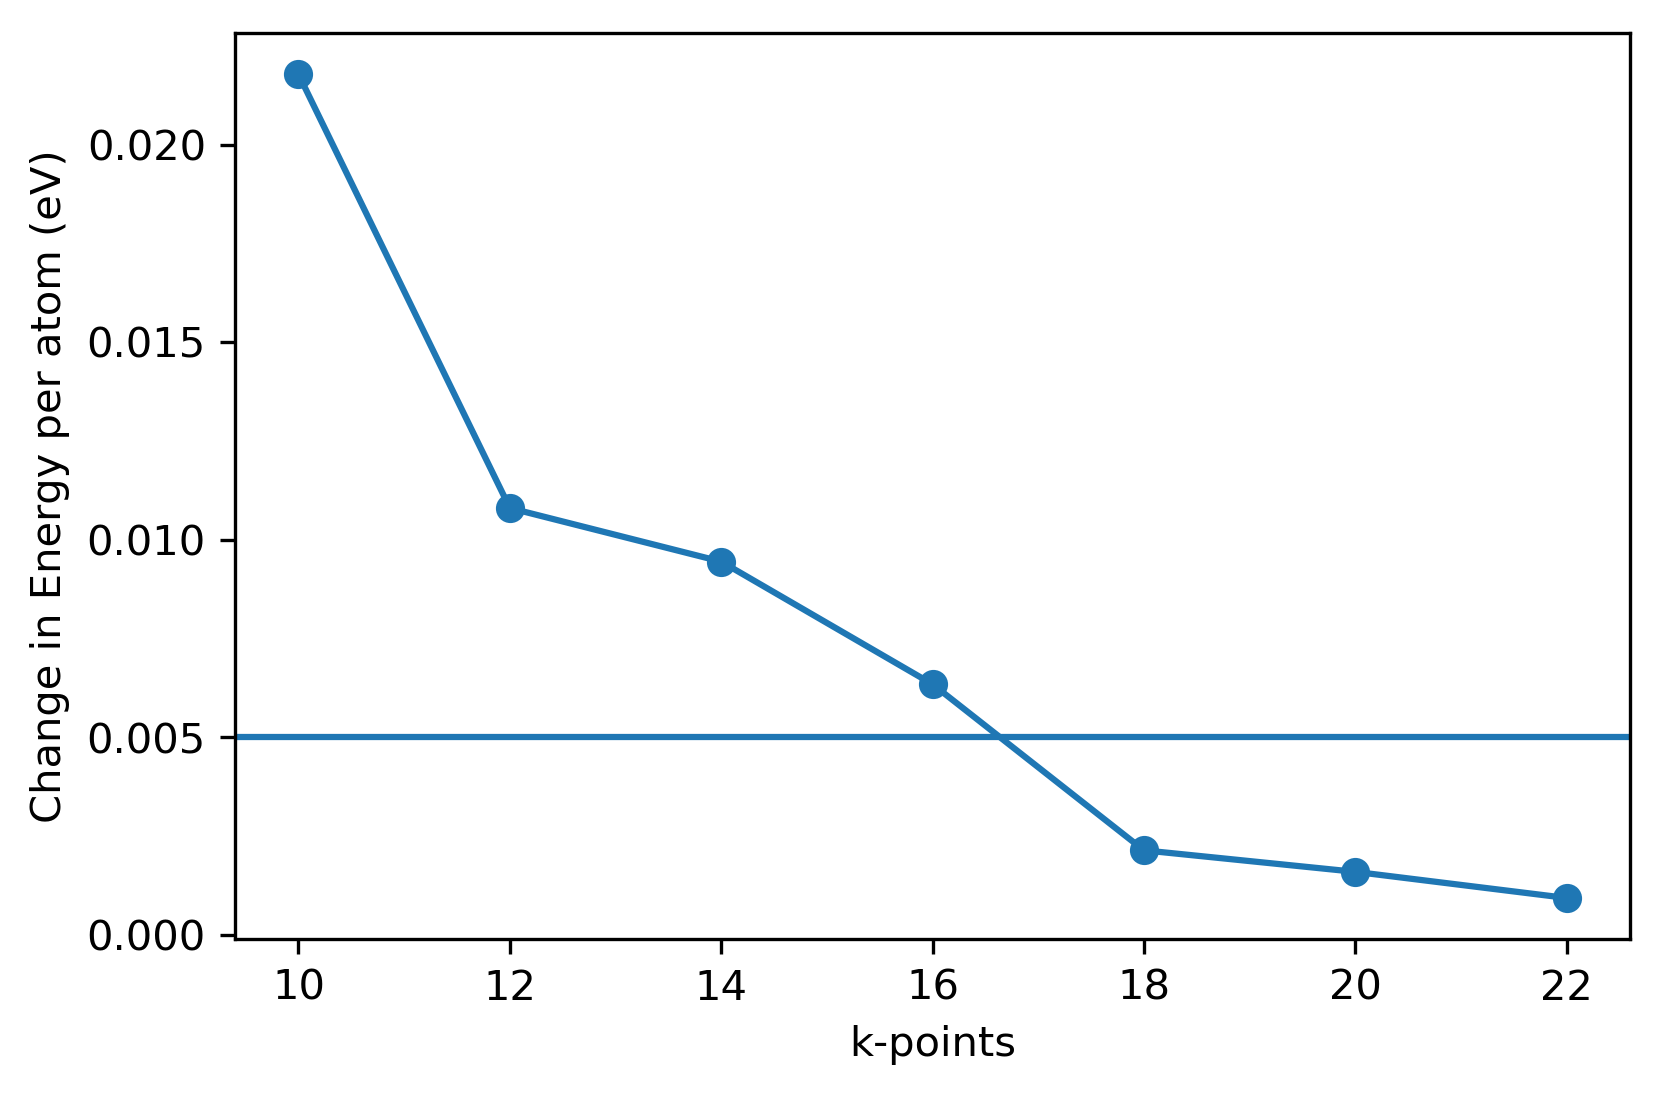

In [7]:
complete_jobs = []
for doc_id in kpoints_ids:
    job = table.get(doc_id=doc_id)
    if job.status == 'Complete':
        job.parse_output()
        complete_jobs.append(job)

data = {
    # energies per atom in eV
    'energies': [job.output.final_total_energy\
                 / len(job.input.structure.sites)\
                 for job in complete_jobs],
    'k_points': [job.input.kpoints_grid[0]\
                 for job in complete_jobs]
}
df = pd.DataFrame(data)
df.sort_values(by='k_points')
df['d_energies'] = [np.abs(df['energies'][i+1] - df['energies'][i])\
                    for i in range(len(df['energies'])-1)] + [np.nan]

fig = plt.figure()
fig.set_dpi(300)
ax = plt.gca()
plt.plot(df['k_points'], df['d_energies'], marker='o')
ax.axhline(0.005)
plt.xlabel('k-points')
plt.ylabel('Change in Energy per atom (eV)')
plt.show()
plt.close()

# Kinetic Energy Cutoff Convergence

### Base configuration

In [8]:
STRUCTURE = m.result[0]['structure']
PSEUDO = pseudo_helper(STRUCTURE, PSEUDO_FAMILY,
                       PSEUDO_TABLE)
base_inputs = {
        'structure': STRUCTURE,

        'control': {
            'calculation': 'scf',
            'verbosity': 'high',
            'disk_io': 'none',
        },
        'system': {
            'ibrav': 0,
            'ecutwfc': None,
            'occupations': 'smearing',
            'degauss': 0.01,
            'smearing': 'mv',
        },
        'electrons': {
            'electron_maxstep': 500,
            'conv_thr': 1.0e-6,
        },
        'ions': {},
        'cell': {},
        'kpoints_mode': 'automatic',
        'kpoints_grid': (None, None, None),
        'kpoints_shift': (0, 0, 0),

        'pseudo': PSEUDO
    }

### Customize, store, and run individual calculations

In [10]:
kpoint = 18
ecutwfcs = [20, 25, 30, 36, 40, 45, 50] # 35 is already in the database!
ecutwfcs_ids = []
ecutwfcs_jobs = []

for ecutwfc in ecutwfcs:
    inputs = copy.deepcopy(base_inputs)
    inputs['system']['ecutwfc'] = ecutwfc
    inputs['kpoints_grid'] = (kpoint, kpoint, kpoint)
    
    runname = 'Alecut{}'.format(ecutwfc)
    calculation = pwcalculation_helper(**inputs, additional_inputs=list(PSEUDO.values()))
    job = SubmitJob(calculation, 'espresso-6.2.1_pw', runname=runname, ncpus=2)
    
    doc_id = job.insert()
    job.submit()
    
    ecutwfcs_jobs.append(job)
    ecutwfcs_ids.append(doc_id)
    
print(ecutwfcs_ids)

Inserted Job d91f54985936 into database with doc_id 9
Submitted job runname Alecut20 hash d91f54985936 submit id 7036682
Updated Job d91f54985936 in database with doc_id 9
Inserted Job 6f3a70b08bdc into database with doc_id 10
Submitted job runname Alecut25 hash 6f3a70b08bdc submit id 7036683
Updated Job 6f3a70b08bdc in database with doc_id 10
Inserted Job ffa5c8c50eea into database with doc_id 11
Submitted job runname Alecut30 hash ffa5c8c50eea submit id 7036685
Updated Job ffa5c8c50eea in database with doc_id 11
Inserted Job c5d0db0ee440 into database with doc_id 12
Submitted job runname Alecut36 hash c5d0db0ee440 submit id 7036686
Updated Job c5d0db0ee440 in database with doc_id 12
Inserted Job b104f51d64f3 into database with doc_id 13
Submitted job runname Alecut40 hash b104f51d64f3 submit id 7036687
Updated Job b104f51d64f3 in database with doc_id 13
Inserted Job 7c6273f55391 into database with doc_id 14
Submitted job runname Alecut45 hash 7c6273f55391 submit id 7036688
Updated Jo

In [11]:
ecutwfcs_ids = [9, 10, 11, 12, 13 , 14, 15]

## Check status

In [12]:
# individual jobs
submitjob_statuses([table.get(doc_id=doc_id) for doc_id in kpoints_ids])
# status as a whole
submit_status()

Updated Job d91f54985936 in database with doc_id 9
Updated Job 6f3a70b08bdc in database with doc_id 10
Updated Job ffa5c8c50eea in database with doc_id 11
Updated Job c5d0db0ee440 in database with doc_id 12
Updated Job b104f51d64f3 in database with doc_id 13
Updated Job 7c6273f55391 in database with doc_id 14
Updated Job 724b29caff10 in database with doc_id 15


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, id='f700757e-6f8a-4470-841c-3b90dbfe07ec', precision=5)

## Parse complete jobs and plot results

In [ ]:
complete_jobs = []
for doc_id in ecutwfcs_ids:
    job = table.get(doc_id=doc_id)
    if job.status == 'Complete':
        job.parse_output()
        complete_jobs.append(job)
        
data = {
    'energies': [job.output.final_total_energy\
                 for job in complete_jobs],
    'ecutwfcs': [job.input.sections['system']['ecutwfc']\
                 for job in complete_jobs]
}
df = pd.DataFrame(data)
df.sort_values(by='ecutwfcs')
df['d_energies'] = [np.abs(df['energies'][i+1] - df['energies'][i])\
                    for i in range(len(df['energies'])-1)] + [np.nan]

fig = plt.figure()
fig.set_dpi(300)
ax = plt.gca()
plt.plot(df['ecutwfcs'], df['d_energies'], marker='o')
ax.axhline(0.001)
plt.xlabel('ecutwfc (Ry)')
plt.ylabel('Change in Energy (eV)')
plt.show()
plt.close()